In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset, TensorDataset

: 

In [96]:
cpu_temp = pd.read_csv("../data/cpu-temp.csv", header=None, names=["time", "cpu_temp"])
fan_speed = pd.read_csv("../data/fan-speed.csv", header=None, names=["time", "fan_speed"])
inlet_temp = pd.read_csv("../data/inlet-temp.csv", header=None, names=["time", "inlet_temp"])
it_power = pd.read_csv("../data/it-power.csv", header=None, names=["time", "it_power"])

In [97]:
def process_dataframe(df, time_col, value_col):
    df[time_col] = df[time_col].astype(int)

    min_time = df[time_col].min()
    max_time = df[time_col].max()
    full_index = pd.DataFrame({time_col: np.arange(min_time, max_time + 1)})

    df_full = pd.merge(full_index, df, on=time_col, how='left')
    df_full[value_col] = df_full[value_col].interpolate(method="polynomial", order=2)

    return df_full

cpu_temp_new = process_dataframe(cpu_temp, "time", "cpu_temp")
fan_speed_new = process_dataframe(fan_speed, "time", "fan_speed")
inlet_temp_new = process_dataframe(inlet_temp, "time", "inlet_temp")
it_power_new = process_dataframe(it_power, "time", "it_power")

In [98]:
max_start = max(inlet_temp_new['time'].min(), cpu_temp_new['time'].min(), it_power_new['time'].min(), fan_speed_new['time'].min())
min_end = min(inlet_temp_new['time'].max(), cpu_temp_new['time'].max(), it_power_new['time'].max(), fan_speed_new['time'].max())

cpu_temp_filtered = cpu_temp_new[(cpu_temp_new['time'] >= max_start) & (cpu_temp_new['time'] <= min_end)]
inlet_temp_filtered = inlet_temp_new[(inlet_temp_new['time'] >= max_start) & (inlet_temp_new['time'] <= min_end)]
it_power_filtered = it_power_new[(it_power_new['time'] >= max_start) & (it_power_new['time'] <= min_end)]
fan_speed_filtered = fan_speed_new[(fan_speed_new['time'] >= max_start) & (fan_speed_new['time'] <= min_end)]

combined_df = pd.merge(cpu_temp_filtered, inlet_temp_filtered, on='time')
combined_df = pd.merge(combined_df, it_power_filtered, on='time')
combined_df = pd.merge(combined_df, fan_speed_filtered, on='time')

combined_df.head()

,time,cpu_temp,inlet_temp,it_power,fan_speed
0,4718,55.766525,22.468243,177.345436,3929.161963
1,4719,55.608490,22.468213,177.350546,3929.225715
2,4720,55.446706,22.468188,177.362315,3929.311931
3,4721,55.238044,22.468170,177.380743,3929.420613
4,4721,54.960208,22.468170,177.380743,3929.420613


In [99]:
combined_df.to_csv("../data/combined_df.csv", index=False)

In [100]:
df = combined_df.copy()
print(f"Shape of Final Dataframe = {df.shape}")

Shape of Final Dataframe = (4255, 5)


In [101]:
scalers = {
    'cpu_temp': MinMaxScaler(),
    'inlet_temp': MinMaxScaler(),
    'it_power': MinMaxScaler(),
    'fan_speed': MinMaxScaler()
}

df_scaled = pd.DataFrame(index=df.index)

for col, scaler in scalers.items():
    df_scaled[col] = scaler.fit_transform(df[[col]]).ravel()

In [102]:
def prepare_data(scaled_df, seq_length=8, k_step=24):
    """
    Prepares the data for the dual-input model.

    Args:
        scaled_df (pd.DataFrame): The scaled DataFrame.
        seq_length (int): Length of the input time series sequence.
        k_step (int): Number of output steps to predict.

    Returns:
        DataLoader, DataLoader, torch.Tensor, int: train_loader, test_loader, all_outputs, split_index
    """

    # Define the input and output features
    features_cols = ['cpu_temp', 'inlet_temp', 'it_power']
    exogenous_col = 'fan_speed'
    output_col = 'cpu_temp'

    # Create sequences
    features = []
    exogenous = []  # Will now hold single scalar values
    outputs = []

    for i in range(len(scaled_df) - seq_length - k_step + 1):
        # Time series features
        features.append(scaled_df[features_cols].iloc[i:i + seq_length].values)

        # Single exogenous scalar (fan_speed)
        exogenous_scalar = scaled_df[exogenous_col].iloc[i + seq_length]  # Fan speed at end of sequence
        exogenous.append(exogenous_scalar)

        # Output sequence (cpu_temp)
        outputs.append(scaled_df[output_col].iloc[i + seq_length:i + seq_length + k_step].values)

    # Convert to numpy array, then to tensor
    features = np.array(features)
    exogenous = np.array(exogenous).reshape(-1, 1)  # Ensure shape (batch_size, 1)
    outputs = np.array(outputs).reshape(-1, k_step, 1)

    # Convert to PyTorch tensors
    features = torch.tensor(features, dtype=torch.float32)
    exogenous = torch.tensor(exogenous, dtype=torch.float32)
    outputs = torch.tensor(outputs, dtype=torch.float32)

    # Split into train and test
    split_ratio = 0.8
    split_index = int(len(features) * split_ratio)
    train_features, test_features = features[:split_index], features[split_index:]
    train_exogenous, test_exogenous = exogenous[:split_index], exogenous[split_index:]
    train_outputs, test_outputs = outputs[:split_index], outputs[split_index:]

    train_dataset = TensorDataset(train_features, train_exogenous, train_outputs)
    test_dataset = TensorDataset(test_features, test_exogenous, test_outputs)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    return train_loader, test_loader, outputs, split_index

In [103]:
class DualInputModel(nn.Module):
    def __init__(self, time_steps, features, output_steps):
        super(DualInputModel, self).__init__()

        # Pathway 1: Time series processing
        self.lstm = nn.LSTM(features, 64, batch_first=True)
        self.attention = nn.MultiheadAttention(embed_dim=64, num_heads=4, batch_first=True)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout1 = nn.Dropout(0.2)

        # Pathway 2: Scalar input processing
        self.scalar_dense = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 16),
            nn.ReLU()
        )

        # Fusion layers
        self.fusion_dense = nn.Sequential(
            nn.Linear(64 + 16, 64),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.output_layer = nn.Linear(64, output_steps)

    def forward(self, time_series, scalar):
        # Pathway 1: Time series processing
        lstm_out, _ = self.lstm(time_series)  # Shape: (batch_size, time_steps, 64)
        attention_out, _ = self.attention(lstm_out, lstm_out, lstm_out)  # Self-attention
        pooled = self.global_pool(attention_out.permute(0, 2, 1)).squeeze(-1)  # Shape: (batch_size, 64)
        pooled = self.dropout1(pooled)

        # Pathway 2: Scalar input processing
        scalar = scalar.unsqueeze(-1) if scalar.dim() == 1 else scalar
        scalar_out = self.scalar_dense(scalar)  # Shape: (batch_size, 16)

        # print(pooled.shape, scalar_out.shape)

        # Fusion
        merged = torch.cat((pooled, scalar_out), dim=1)  # Shape: (batch_size, 64 + 16)
        fused = self.fusion_dense(merged)  # Shape: (batch_size, 64)

        # Output
        output = self.output_layer(fused)  # Shape: (batch_size, output_steps)
        return output

In [104]:
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=20):
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for time_series, scalar, target in train_loader:
            time_series = time_series.float()
            scalar = scalar.float()
            target = target.float()
            target = target.squeeze(-1) # <----- remove singleton dimensions

            # Forward pass
            predictions = model(time_series, scalar)
            loss = criterion(predictions, target)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Validation
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for time_series, scalar, target in test_loader:
                time_series = time_series.float()
                scalar = scalar.float()
                target = target.float()
                target = target.squeeze(-1) # <----- remove singleton dimensions
                predictions = model(time_series, scalar)
                val_loss += criterion(predictions, target).item()
        
        model.train()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}, Validation Loss: {val_loss / len(test_loader):.4f}")

In [105]:
time_steps = 25
features = 3
output_steps = 20
batch_size = 32
learning_rate = 0.001

# Sample data preparation (scaled_df should be prepared as per the provided prepare_data function)
# Assume train_loader, test_loader, _, _ are returned by prepare_data

train_loader, test_loader, all_outputs, split_index = prepare_data(df_scaled, seq_length=time_steps, k_step=output_steps)

# Model, loss, and optimizer
model = DualInputModel(time_steps, features, output_steps)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_model(model, train_loader, test_loader, criterion, optimizer, epochs=20)


Epoch 1/20, Loss: 0.0973, Validation Loss: 0.0167
Epoch 2/20, Loss: 0.0189, Validation Loss: 0.0066
Epoch 3/20, Loss: 0.0140, Validation Loss: 0.0045
Epoch 4/20, Loss: 0.0114, Validation Loss: 0.0050
Epoch 5/20, Loss: 0.0104, Validation Loss: 0.0062
Epoch 6/20, Loss: 0.0094, Validation Loss: 0.0076
Epoch 7/20, Loss: 0.0087, Validation Loss: 0.0079
Epoch 8/20, Loss: 0.0084, Validation Loss: 0.0081
Epoch 9/20, Loss: 0.0084, Validation Loss: 0.0092
Epoch 10/20, Loss: 0.0076, Validation Loss: 0.0088
Epoch 11/20, Loss: 0.0073, Validation Loss: 0.0097
Epoch 12/20, Loss: 0.0071, Validation Loss: 0.0091
Epoch 13/20, Loss: 0.0068, Validation Loss: 0.0108
Epoch 14/20, Loss: 0.0065, Validation Loss: 0.0101
Epoch 15/20, Loss: 0.0065, Validation Loss: 0.0095
Epoch 16/20, Loss: 0.0064, Validation Loss: 0.0093
Epoch 17/20, Loss: 0.0062, Validation Loss: 0.0084
Epoch 18/20, Loss: 0.0063, Validation Loss: 0.0086
Epoch 19/20, Loss: 0.0059, Validation Loss: 0.0077
Epoch 20/20, Loss: 0.0057, Validation Lo

In [106]:
from sklearn.metrics import mean_squared_error, r2_score

In [107]:
def evaluate_model(model, test_loader, scaler, df, k_step, all_outputs, split_index):
    model.eval()
    criterion = nn.MSELoss()
    test_loss = 0
    predictions = []
    actuals = []
    with torch.no_grad():
        for batch_features, batch_exogenous, batch_outputs in test_loader:
             batch_outputs = batch_outputs.squeeze(-1) # Squeeze batch outputs
             outputs = model(batch_features, batch_exogenous)
             loss = criterion(outputs, batch_outputs)
             test_loss += loss.item()
             predictions.append(outputs.cpu().numpy()) # moved predictions and actuals to cpu
             actuals.append(batch_outputs.cpu().numpy())
    test_loss /= len(test_loader)
    print(f"Test Loss: {test_loss:.4f}")

    # Convert predictions and actuals to numpy array and rescale
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)


    # Create a dataframe using the original dataframe index and actual values
    actual_df = df.iloc[split_index:split_index + len(actuals)].copy()
    for i in range(k_step):
        actual_df[f'actual_cpu_temp_{i+1}'] = actuals[:,i]

    # Create a dataframe from predictions using the same index as the actual values
    predictions_df = actual_df.copy()
    for i in range(k_step):
        predictions_df[f'predicted_cpu_temp_{i+1}'] = predictions[:,i]


    #Inverse scale the predicted and actual values
    for i in range(k_step):
        original_data = scaler.inverse_transform(predictions_df[['cpu_temp','inlet_temp', 'it_power', f'predicted_cpu_temp_{i+1}']].values)
        predictions_df[f'predicted_cpu_temp_{i+1}'] = original_data[:,-1]

        original_data_actual = scaler.inverse_transform(actual_df[['cpu_temp','inlet_temp', 'it_power', f'actual_cpu_temp_{i+1}']].values)
        predictions_df[f'actual_cpu_temp_{i+1}'] = original_data_actual[:,-1]


    predictions_df.reset_index(inplace=True)

    # Calculate R2 scores
    r2_scores = []
    for i in range(k_step):
        r2 = r2_score(predictions_df[f'actual_cpu_temp_{i+1}'], predictions_df[f'predicted_cpu_temp_{i+1}'])
        r2_scores.append(r2)
        print(f"R2 Score for Step {i+1}: {r2:.4f}")
    average_r2 = np.mean(r2_scores)
    print(f"Average R2 Score: {average_r2:.4f}")


    return predictions_df, test_loss, r2_scores, average_r2

In [108]:
def plot_results(predictions_df, history, k_step, r2_scores):
    """
    Plots predicted vs actual CPU temperatures for each step and training/test loss.

    Args:
        predictions_df (pd.DataFrame): DataFrame with predicted and actual values.
        history (dict): Dictionary containing training and test loss histories.
        k_step (int): Number of prediction steps.
        r2_scores (list): List of R2 scores for each step.
    """

    for i in range(k_step):
        plt.figure(figsize=(12, 6))
        plt.plot(predictions_df.index, predictions_df[f'predicted_cpu_temp_{i+1}'], label=f'Predicted CPU Temp {i+1}', color='red')
        plt.plot(predictions_df.index, predictions_df[f'actual_cpu_temp_{i+1}'], label=f'Actual CPU Temp {i+1}', color='blue', alpha=0.6)
        plt.xlabel('Time Step')
        plt.ylabel('CPU Temperature')
        plt.title(f'Predicted vs Actual CPU Temperature - Step {i+1}, R2: {r2_scores[i]:.4f}')
        plt.legend()
        plt.tight_layout() # Ensures labels do not overlap
        plt.show()

    if history: # Checks if the history exists
        plt.figure(figsize=(12, 6))
        plt.plot(history['train_loss'], label='Training Loss', color='green')
        plt.plot(history['test_loss'], label='Test Loss', color='orange')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Test Loss')
        plt.legend()
        plt.tight_layout() # Ensures labels do not overlap
        plt.show()

In [109]:
predictions_df, test_loss, r2_scores, average_r2 = evaluate_model(model, test_loader, scalers["cpu_temp"], df, output_steps, all_outputs, split_index)

Test Loss: 0.0082
R2 Score for Step 1: 0.8897
R2 Score for Step 2: 0.8905
R2 Score for Step 3: 0.9134
R2 Score for Step 4: 0.9079
R2 Score for Step 5: 0.8809
R2 Score for Step 6: 0.9039
R2 Score for Step 7: 0.9113
R2 Score for Step 8: 0.9162
R2 Score for Step 9: 0.9187
R2 Score for Step 10: 0.9285
R2 Score for Step 11: 0.9044
R2 Score for Step 12: 0.9241
R2 Score for Step 13: 0.8887
R2 Score for Step 14: 0.9154
R2 Score for Step 15: 0.9231
R2 Score for Step 16: 0.9147
R2 Score for Step 17: 0.9296
R2 Score for Step 18: 0.9195
R2 Score for Step 19: 0.9104
R2 Score for Step 20: 0.9071
Average R2 Score: 0.9099


In [110]:
predictions_df.to_csv("../data/predictions_df.csv", index=False)

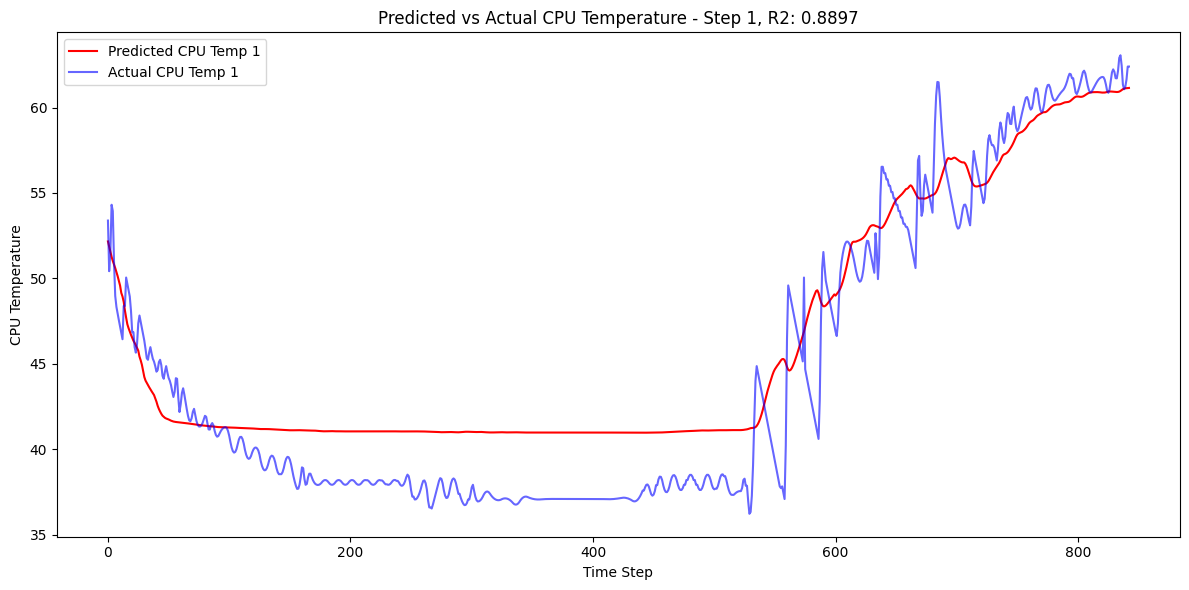

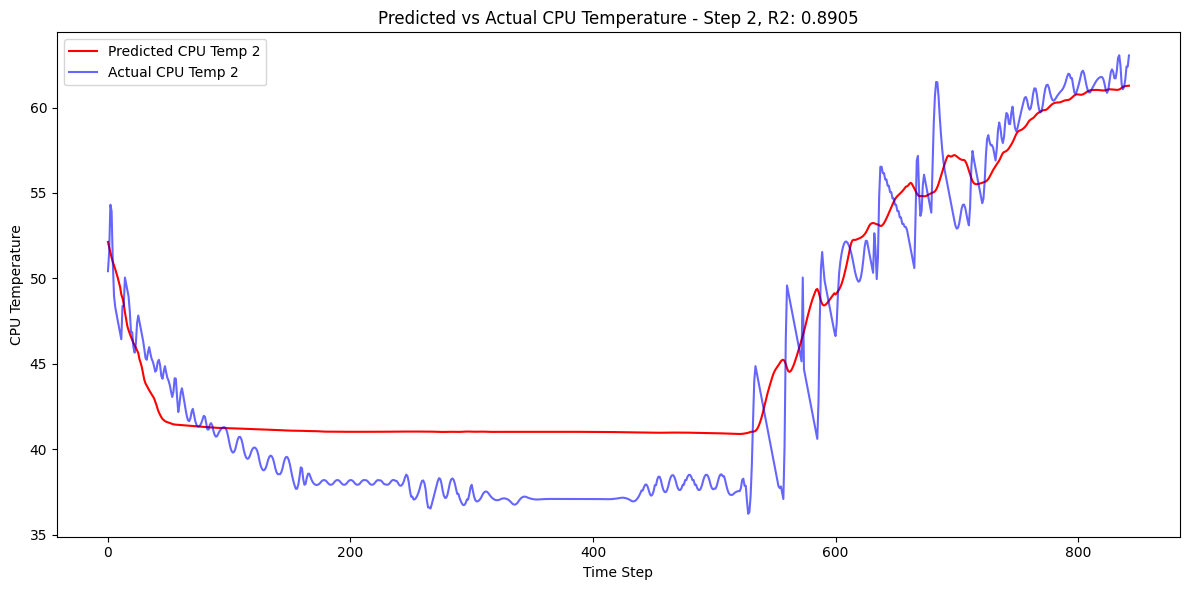

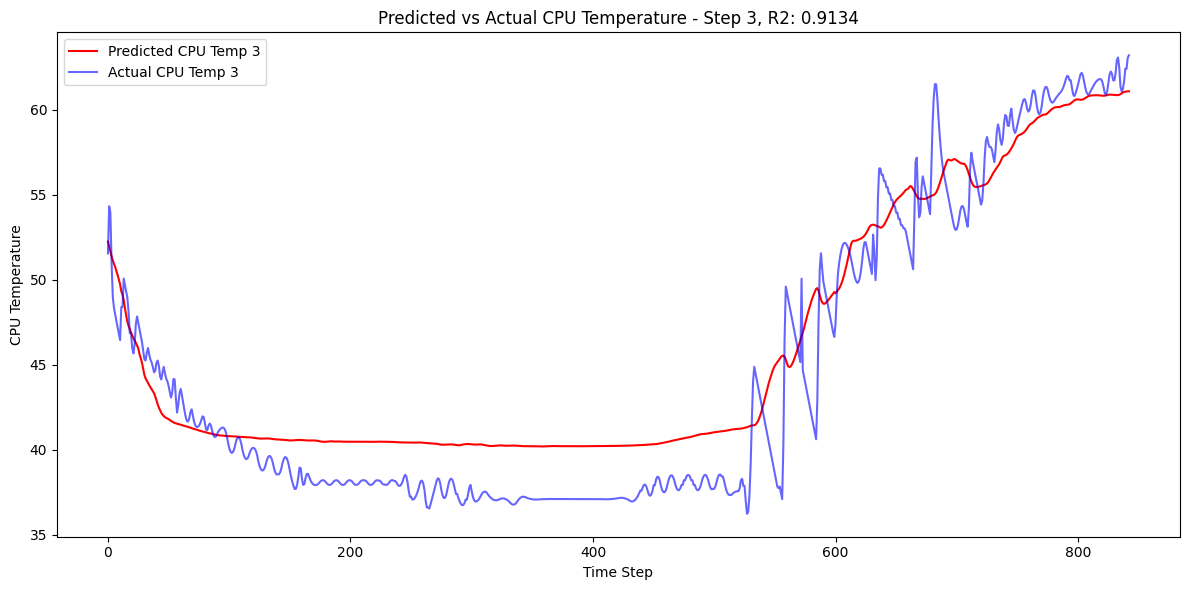

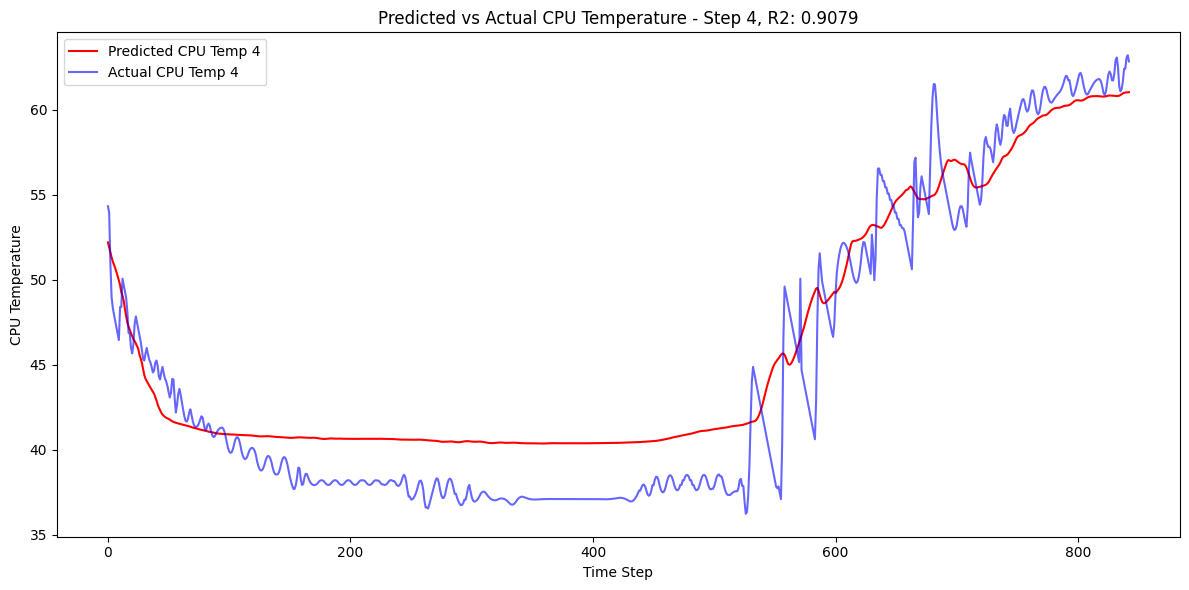

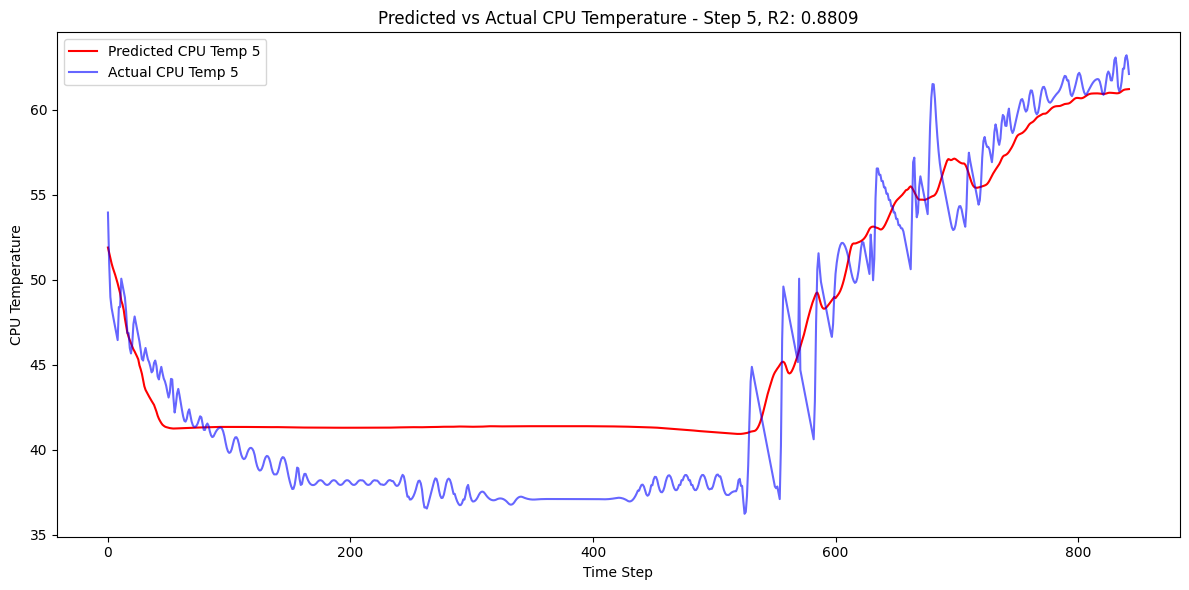

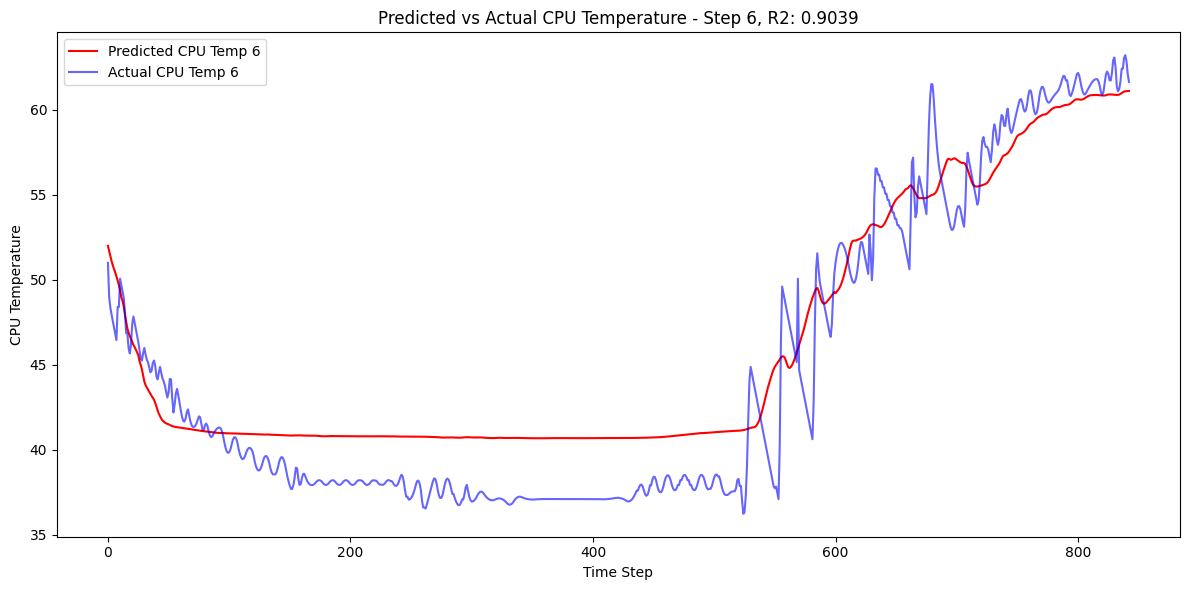

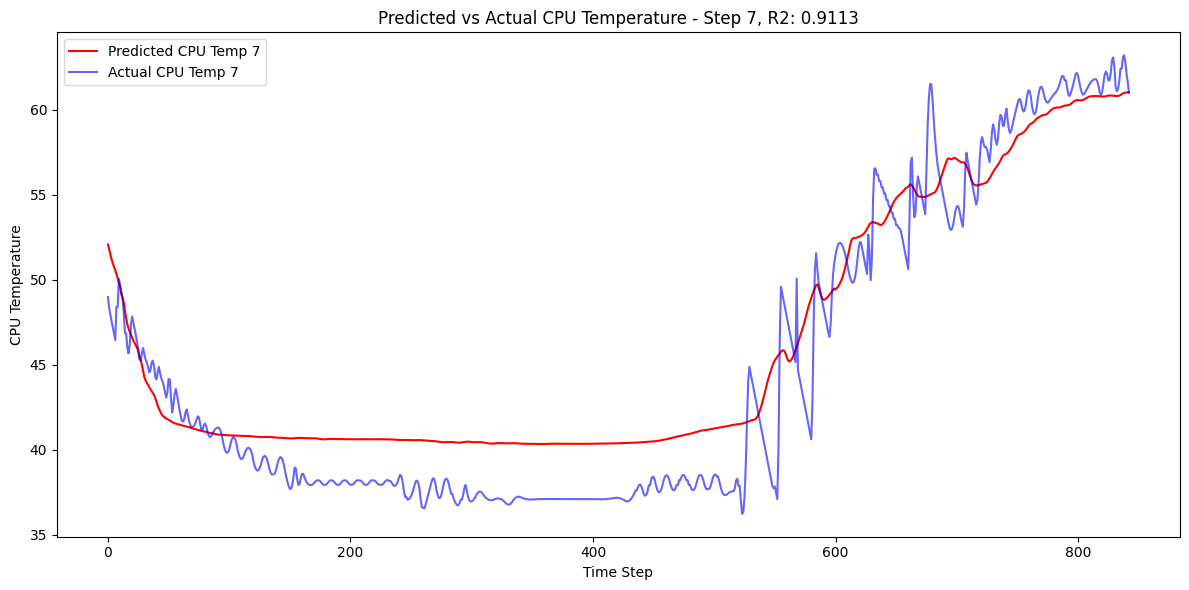

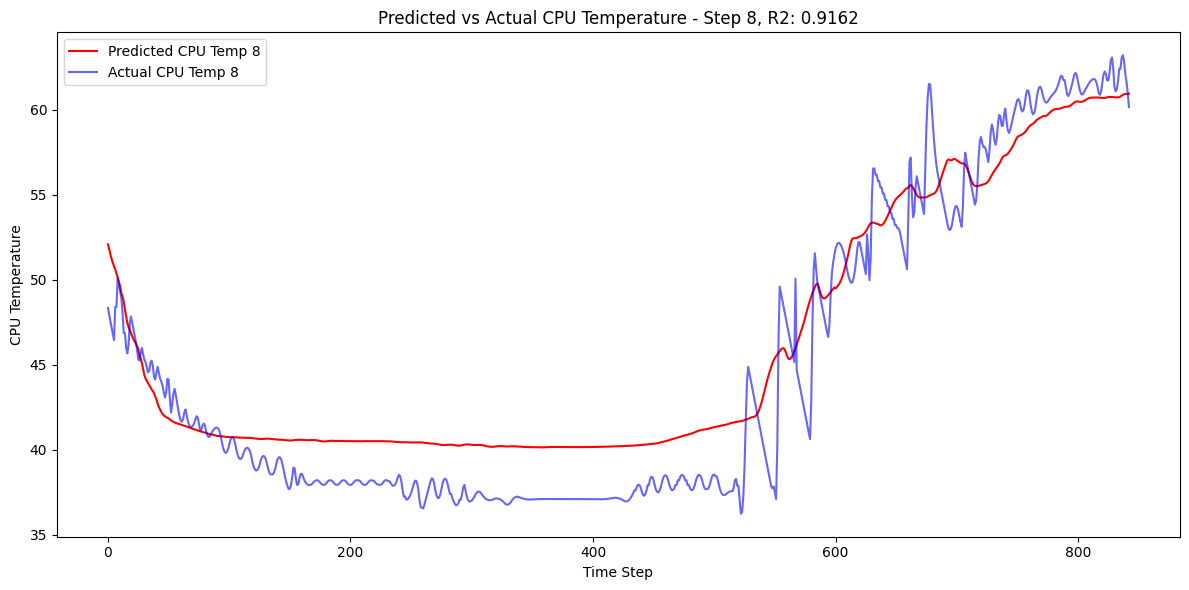

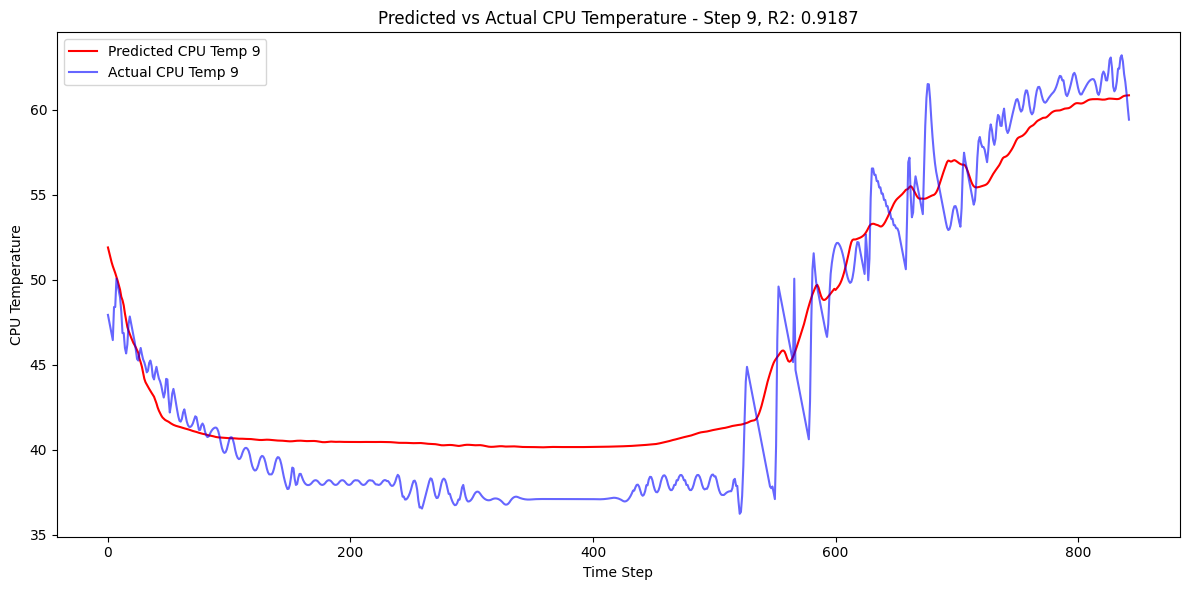

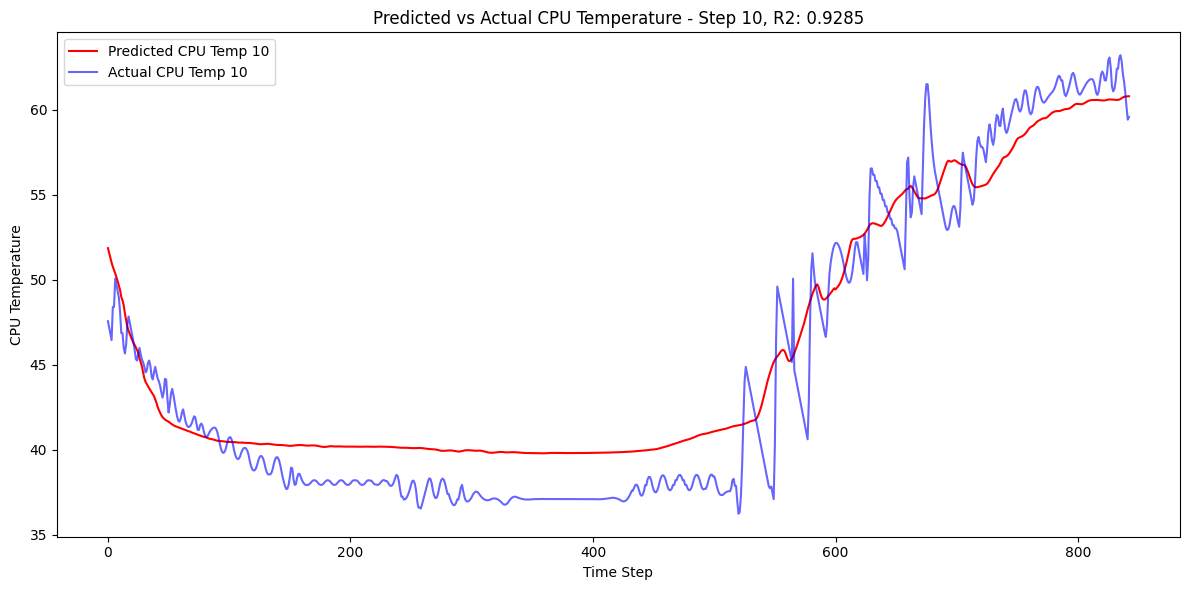

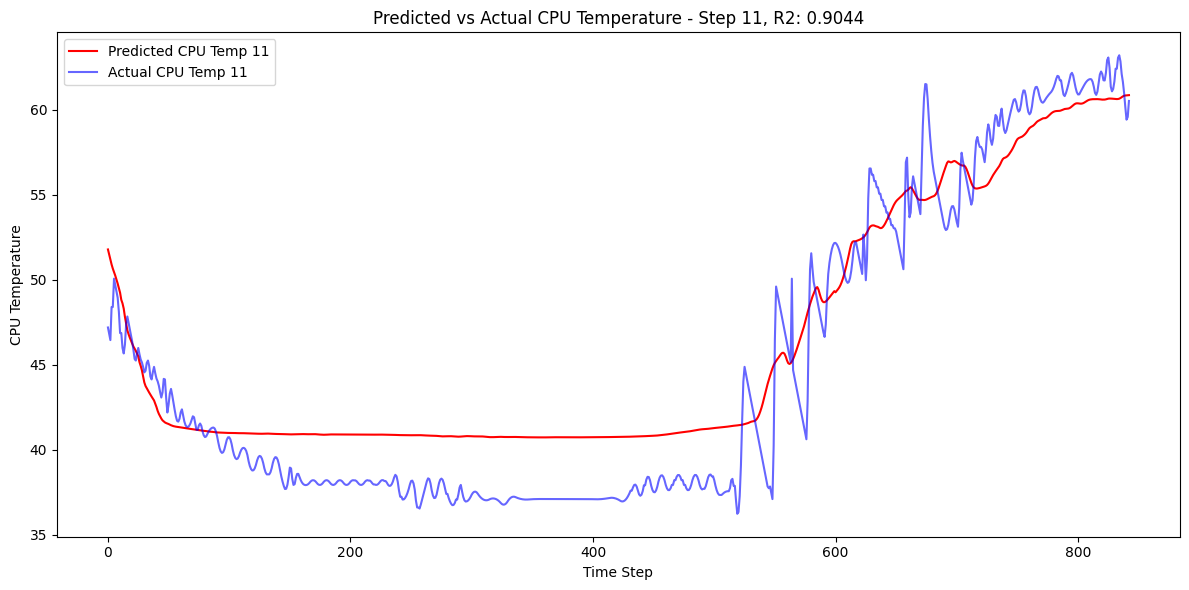

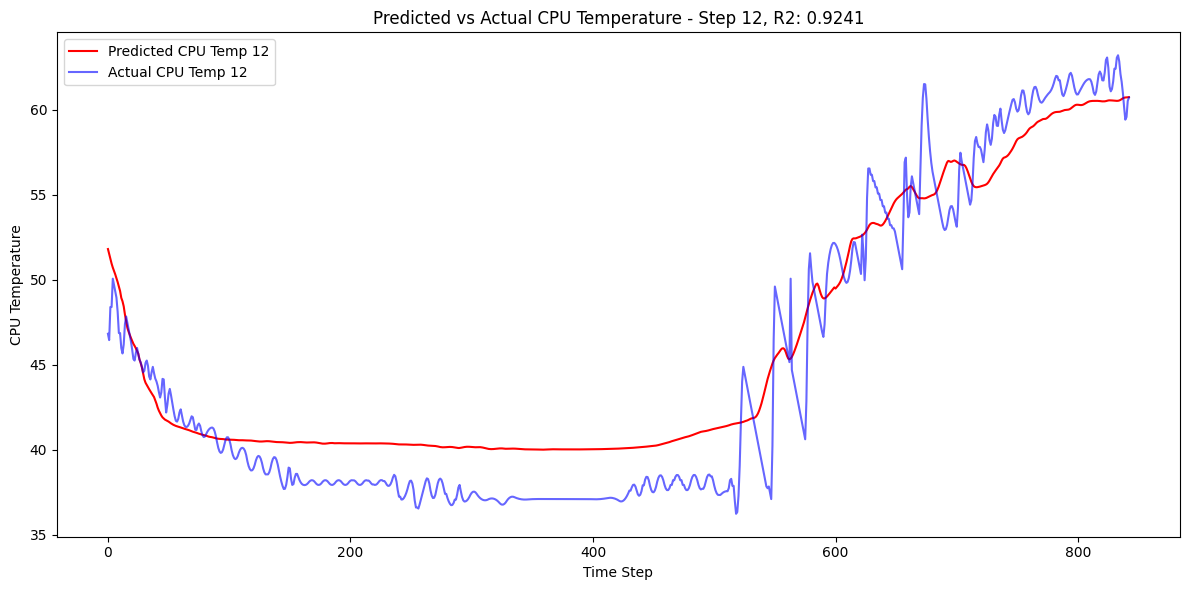

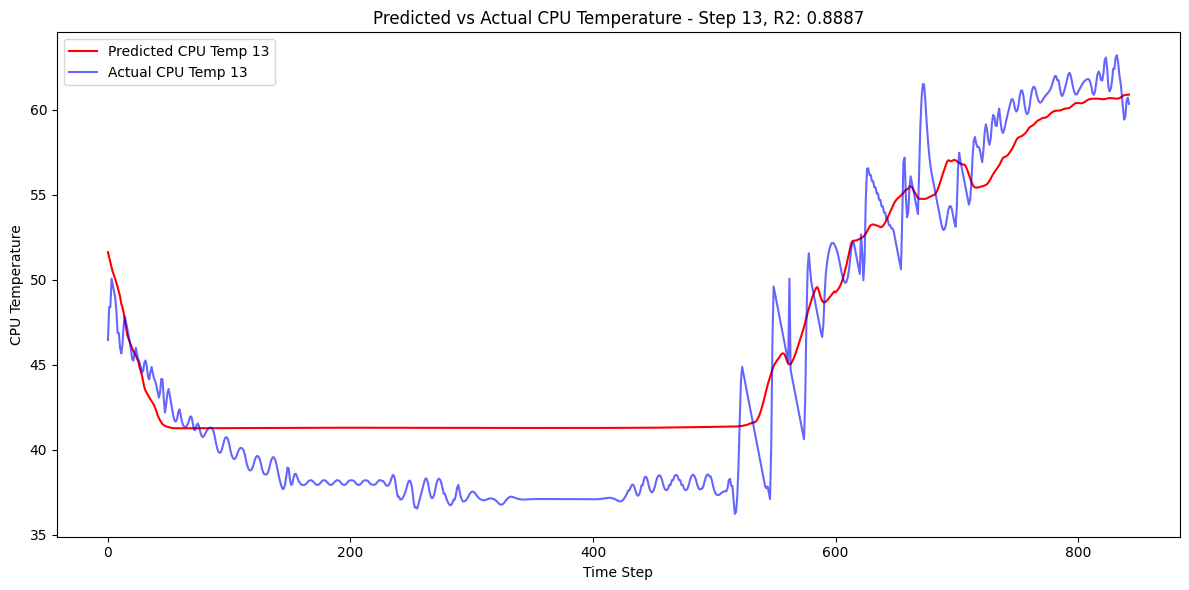

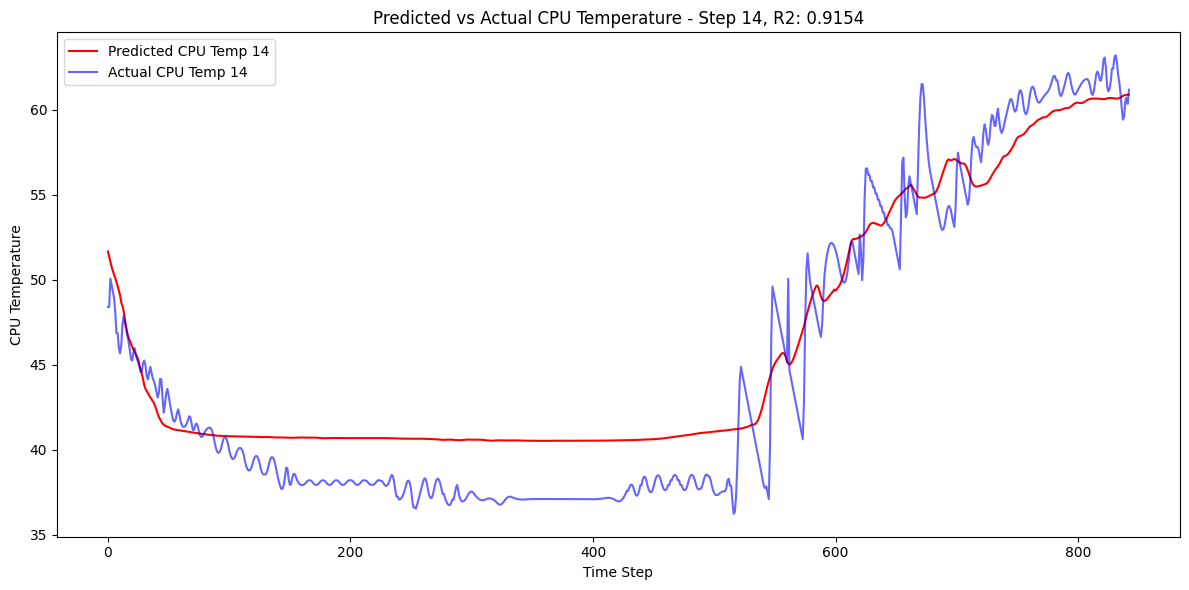

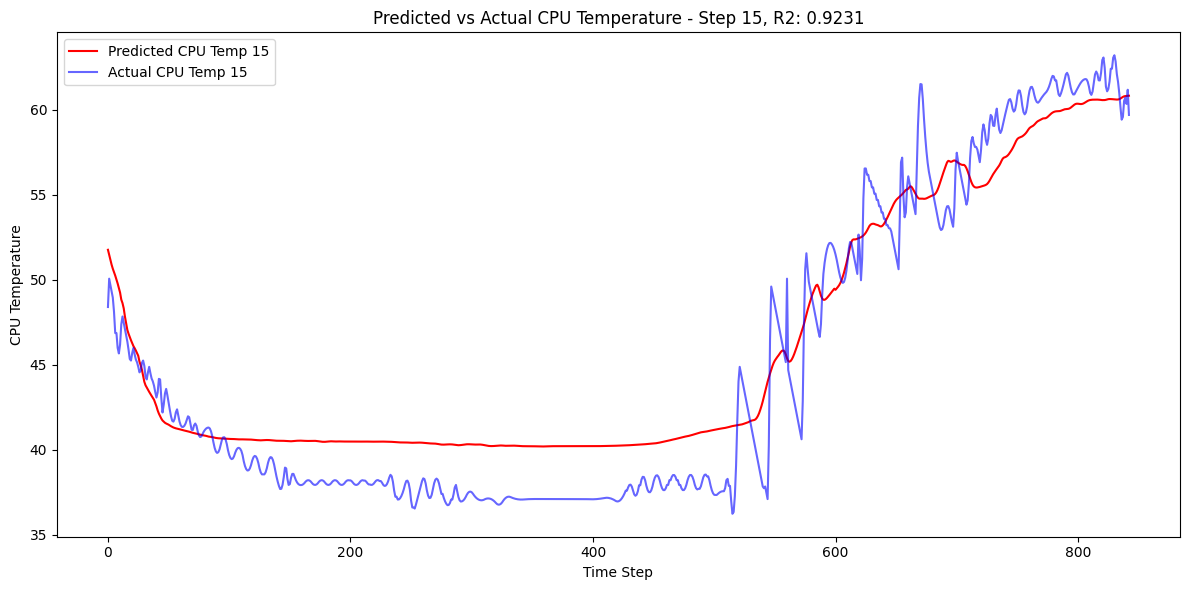

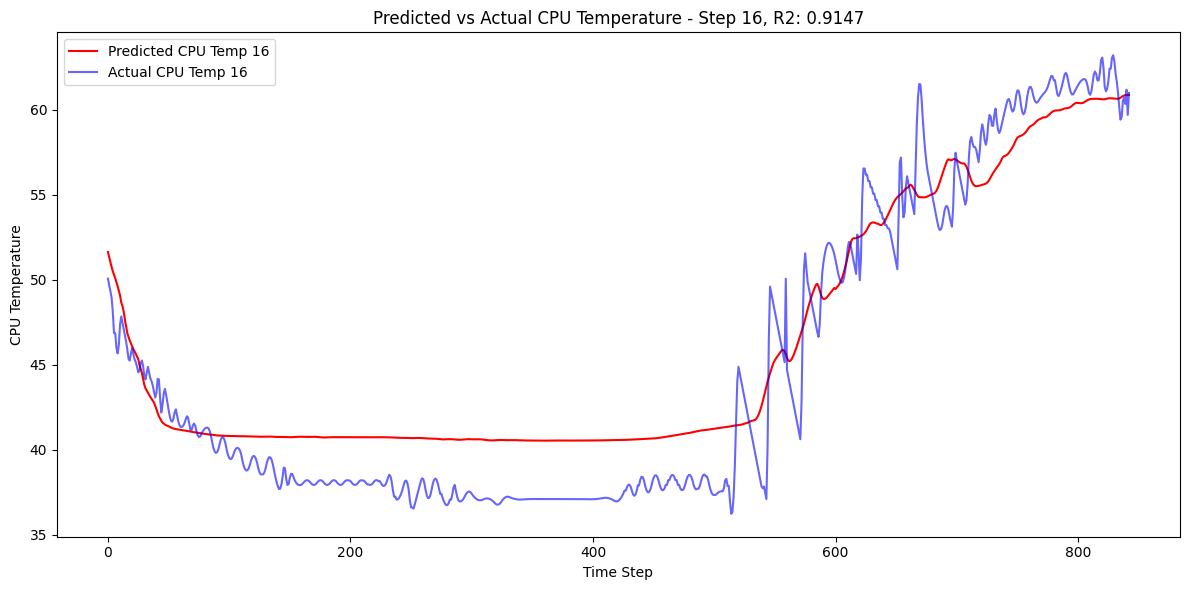

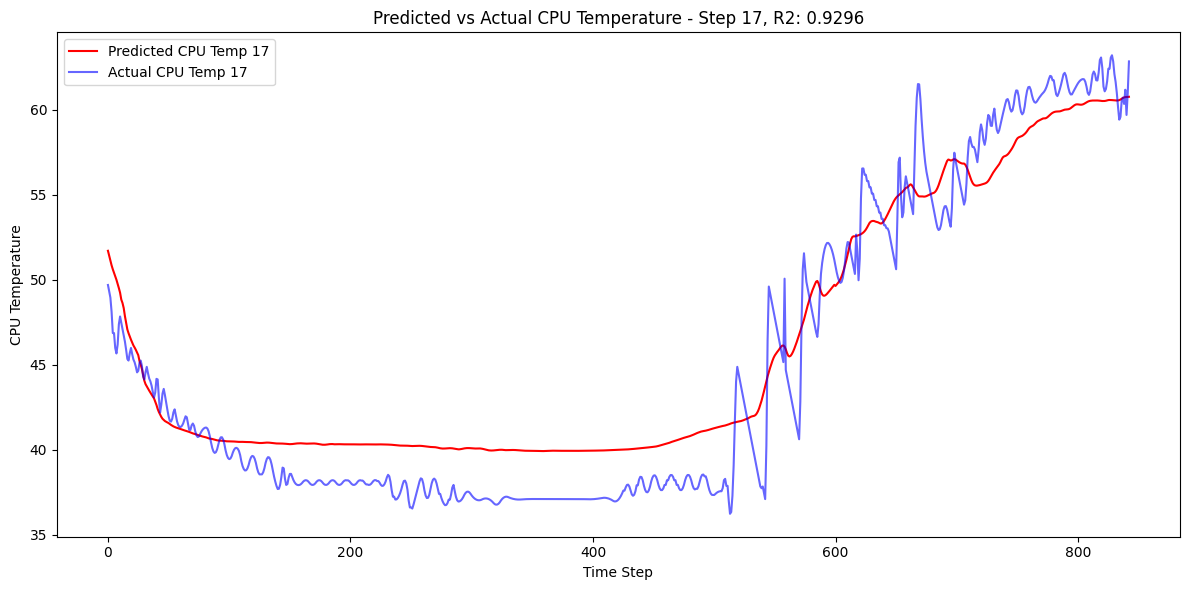

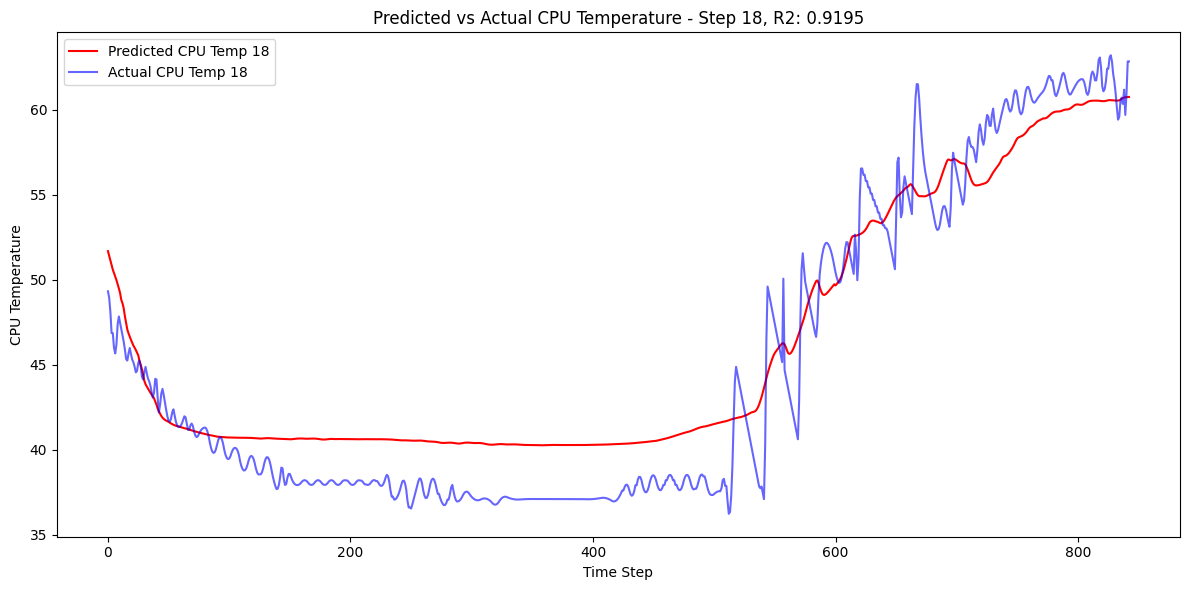

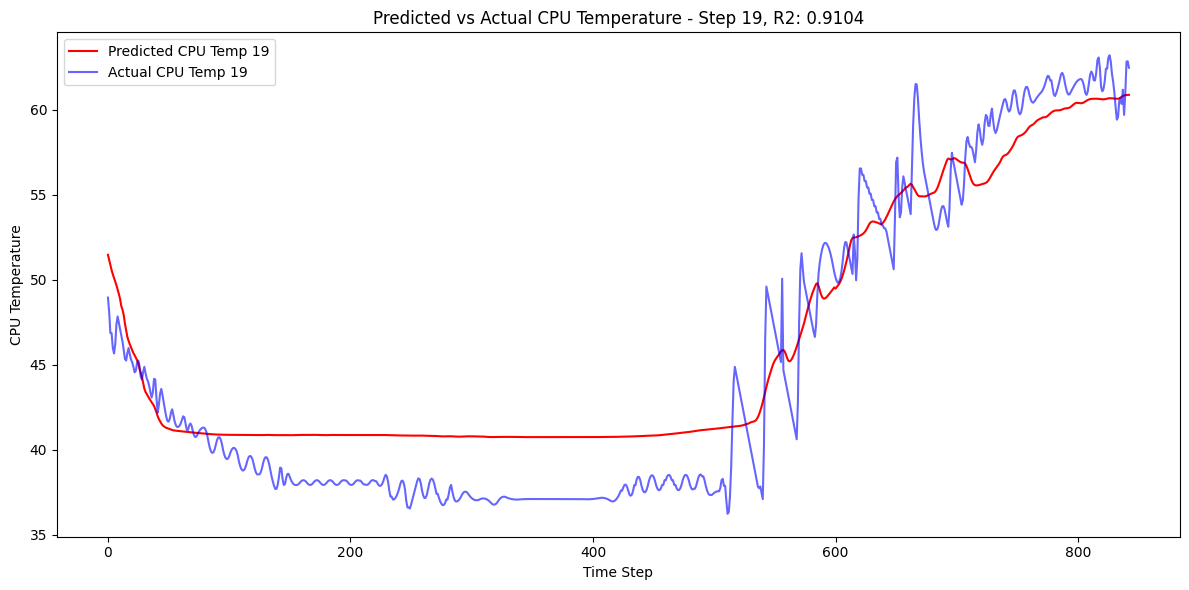

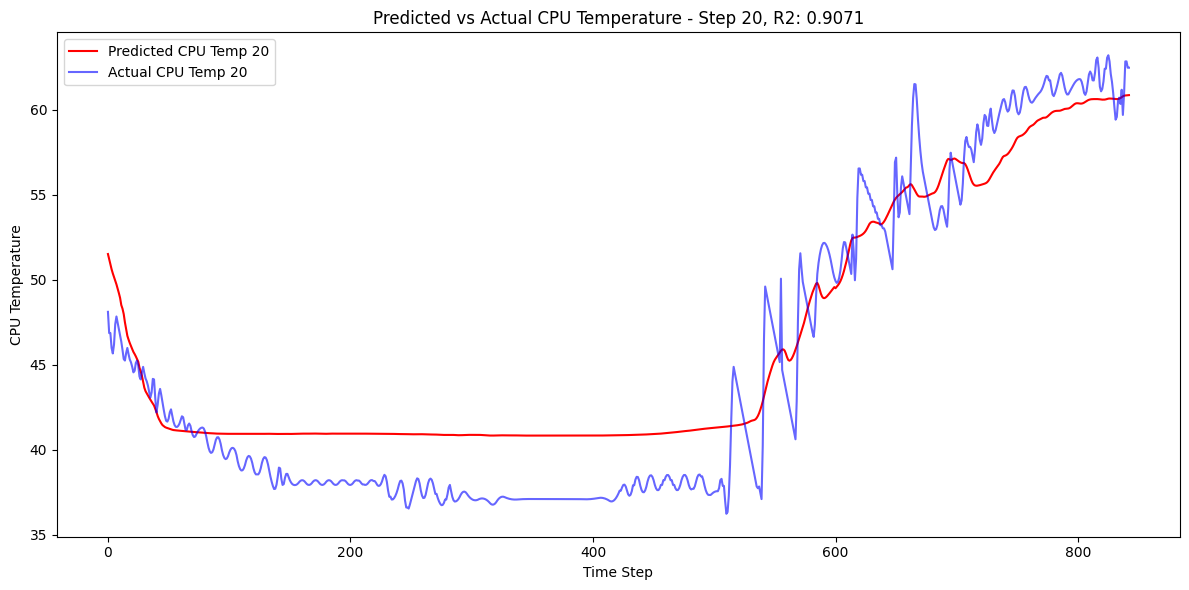

In [111]:
plot_results(predictions_df, False, output_steps, r2_scores)